### How to build machine learning models for imbalanced datasets**





<b>  A. Install imbalanced-learn </b>

In [1]:
! pip install -U imbalanced-learn

     |████████████████████████████████| 199 kB 4.1 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


# **B. Read data**

In [9]:
import pandas as pd

df = pd.read_csv('/content/hcv_classification.csv', index_col=False)


In [10]:
df.head(5)

,Unnamed: 0,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,Activity
0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,active
1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,active
2,2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,active
3,3,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,active
4,4,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,active


<p> "Activity" is target variable </p>

In [11]:
X = df.drop(['Activity'], axis=1)
y = df['Activity']

# **C. Class distribution**

In [12]:
activity_count = y.value_counts()
activity_count

active      412
inactive    166
Name: Activity, dtype: int64

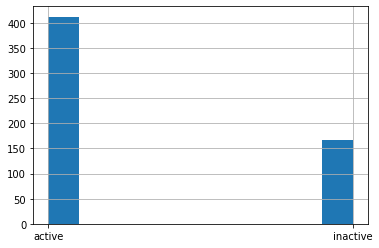

In [20]:
df['Activity'].hist()

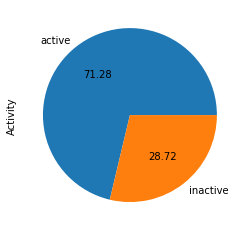

In [13]:
# Show pie plot (Approach 1)
y.value_counts().plot.pie(autopct='%.2f')

([<matplotlib.patches.Wedge at 0x7fae672c61d0>,
 [Text(-0.6818247054992795, 0.8632004813314349, 'active'),
  Text(0.6818247054992798, -0.8632004813314348, 'inactive')],
 [Text(-0.3719043848177888, 0.4708366261807826, '71.28'),
  Text(0.3719043848177889, -0.47083662618078254, '28.72')])

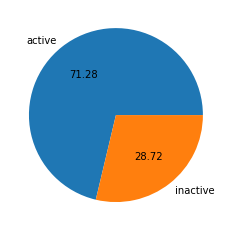

In [14]:
# Show pie plot (Approach 2)
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.pie(y.value_counts(), autopct='%.2f', labels=activity_count.index)

In [15]:
activity_count.index

Index(['active', 'inactive'], dtype='object')

# **D. Data splitting**

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((462, 882), (462,), (116, 882), (116,))

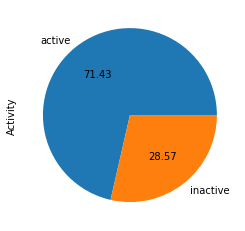

In [18]:
# Pie chart of the training set
y_train.value_counts().plot.pie(autopct='%.2f')

In [19]:
y_train.value_counts()

active      330
inactive    132
Name: Activity, dtype: int64

# **E. Class balancing**

### **Random Undersampling**

``'not minority'`` = resample all classes but the minority class

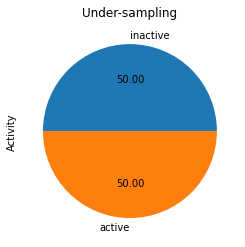

In [21]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=1) # Numerical value
# rus = RandomUnderSampler(sampling_strategy="not minority") # String
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

ax = y_train_rus.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

In [22]:
# Class distribution
y_train_rus.value_counts()

inactive    132
active      132
Name: Activity, dtype: int64

### **Random Oversampling**

``"not majority"`` = resample all classes but the majority class



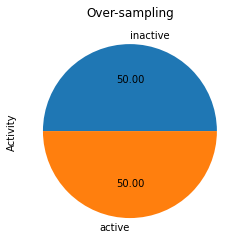

In [23]:
from imblearn.over_sampling import RandomOverSampler

#ros = RandomOverSampler(sampling_strategy=1) # Float
ros = RandomOverSampler(sampling_strategy="not majority") # String
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

ax = y_train_ros.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling")

In [24]:
y_train_ros.value_counts()

inactive    330
active      330
Name: Activity, dtype: int64

---

# **F. Model building with/without class balancing**

### **1. Model building without class balancing**

In [25]:
# Training Random Forest Models
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Training Cross-validation Models
from sklearn.metrics import make_scorer, recall_score, matthews_corrcoef
from sklearn.model_selection import cross_validate

model_cv = RandomForestClassifier(random_state=42)
cv_scoring = {'MCC': make_scorer(matthews_corrcoef)}
cv = cross_validate(model_cv, X_train, y_train, cv=5, scoring=cv_scoring)

# Apply model to make prediction
from sklearn.metrics import matthews_corrcoef

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
  
mcc_train = matthews_corrcoef(y_train, y_train_pred)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
mcc_cv = cv['test_MCC'].mean()

# Display model performance results
df_labels = pd.Series(['MCC_train', 'MCC_CV', 'MCC_test'], name = 'Performance_metric_names')
df_values = pd.Series([mcc_train, mcc_cv, mcc_test], name = 'Performance_metric_values')
df1 = pd.concat([df_labels, df_values], axis=1)
df1

,Performance_metric_names,Performance_metric_values
0,MCC_train,1.000000
1,MCC_CV,0.872161
2,MCC_test,0.765405


### **2. Model building with undersampled balanced class**

In [26]:
# Training Random Forest Models
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train_rus, y_train_rus)

# Training Cross-validation Models
from sklearn.metrics import make_scorer, recall_score, matthews_corrcoef
from sklearn.model_selection import cross_validate

model_cv = RandomForestClassifier(random_state=42)
cv_scoring = {'MCC': make_scorer(matthews_corrcoef)}
cv = cross_validate(model_cv, X_train_rus, y_train_rus, cv=5, scoring=cv_scoring)

# Apply model to make prediction
from sklearn.metrics import matthews_corrcoef

y_train_pred = model.predict(X_train_rus)
y_test_pred = model.predict(X_test)
  
mcc_train = matthews_corrcoef(y_train_rus, y_train_pred)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
mcc_cv = cv['test_MCC'].mean()

# Display model performance results
df_labels = pd.Series(['MCC_train', 'MCC_CV', 'MCC_test'], name = 'Performance_metric_names')
df_values = pd.Series([mcc_train, mcc_cv, mcc_test], name = 'Performance_metric_values')
df2 = pd.concat([df_labels, df_values], axis=1)
df2

,Performance_metric_names,Performance_metric_values
0,MCC_train,1.000000
1,MCC_CV,0.858035
2,MCC_test,0.809468


### **3. Model building with oversampled balanced class**

In [27]:
# Training Random Forest Models
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train_ros, y_train_ros)

# Training Cross-validation Models
from sklearn.metrics import make_scorer, recall_score, matthews_corrcoef
from sklearn.model_selection import cross_validate

model_cv = RandomForestClassifier(random_state=42)
cv_scoring = {'MCC': make_scorer(matthews_corrcoef)}
cv = cross_validate(model_cv, X_train_ros, y_train_ros, cv=5, scoring=cv_scoring)

# Apply model to make prediction
from sklearn.metrics import matthews_corrcoef

y_train_pred = model.predict(X_train_ros)
y_test_pred = model.predict(X_test)
  
mcc_train = matthews_corrcoef(y_train_ros, y_train_pred)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
mcc_cv = cv['test_MCC'].mean()

# Display model performance results
df_labels = pd.Series(['MCC_train', 'MCC_CV', 'MCC_test'], name = 'Performance_metric_names')
df_values = pd.Series([mcc_train, mcc_cv, mcc_test], name = 'Performance_metric_values')
df3 = pd.concat([df_labels, df_values], axis=1)
df3

,Performance_metric_names,Performance_metric_values
0,MCC_train,1.000000
1,MCC_CV,0.949482
2,MCC_test,0.831402


### **4. Model building with Class weight balancing**

In [28]:
# Training Random Forest Models
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42, class_weight='balanced') # Class weight balancing
model.fit(X_train, y_train)

# Training Cross-validation Models
from sklearn.metrics import make_scorer, recall_score, matthews_corrcoef
from sklearn.model_selection import cross_validate

model_cv = RandomForestClassifier(random_state=42, class_weight='balanced') # Class weight balancing
cv_scoring = {'MCC': make_scorer(matthews_corrcoef)}
cv = cross_validate(model_cv, X_train, y_train, cv=5, scoring=cv_scoring)

# Apply model to make prediction
from sklearn.metrics import matthews_corrcoef

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
  
mcc_train = matthews_corrcoef(y_train, y_train_pred)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
mcc_cv = cv['test_MCC'].mean()

# Display model performance results
df_labels = pd.Series(['MCC_train', 'MCC_CV', 'MCC_test'], name = 'Performance_metric_names')
df_values = pd.Series([mcc_train, mcc_cv, mcc_test], name = 'Performance_metric_values')
df4 = pd.concat([df_labels, df_values], axis=1)
df4

,Performance_metric_names,Performance_metric_values
0,MCC_train,1.000000
1,MCC_CV,0.877831
2,MCC_test,0.809142


# **G. Summary of Model performance**

### **Summary Table**

In [29]:
df = pd.concat([df1.Performance_metric_values,
                df2.Performance_metric_values,
                df3.Performance_metric_values,
                df4.Performance_metric_values], axis=1)
df.columns = ['No class balancing', 'Class balancing (undersampling)', 'Class balancing (oversampling)', 'Class balancing (class weights)']
df = df.T
df.columns = ['Training', 'CV', 'Test']
df

,Training,CV,Test
No class balancing,1.0,0.872161,0.765405
Class balancing (undersampling),1.0,0.858035,0.809468
Class balancing (oversampling),1.0,0.949482,0.831402
Class balancing (class weights),1.0,0.877831,0.809142


In [30]:
df.to_latex('summary_table.txt')

### **Polar plots**

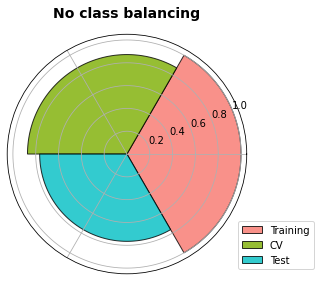

In [31]:
# No class balancing

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

data = df.iloc[0,:]

N = len(data)
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = data
width = 2 * np.pi / N

ax = plt.subplot(111, polar=True)

bars = ax.bar(theta, radii, width=width, bottom=0.0)
ax.xaxis.set_ticks(theta)

#ax.set_xticklabels(radii.index, fontsize=14)
ax.set_xticklabels(['','',''])
ax.tick_params(axis='x', which='major')

cmap = colors.ListedColormap(['#F8766D', '#7CAE00', '#00BFC4'])

for r, bar in zip(theta, bars):
    #bar.set_facecolor(plt.cm.hsv(r / np.pi / 2))
    bar.set_facecolor(cmap(r / np.pi / 2))
    bar.set_alpha(0.8)
    bar.set_edgecolor('black')

ax.legend(bars, radii.index, loc='lower right', bbox_to_anchor=(1.3, 0) )

ax.set_title('No class balancing', fontsize=14, fontweight='bold', pad=5) # Training set

plt.tight_layout()
plt.savefig('Figure_polarplot_MCC_df1.pdf')

In [32]:
theta

array([0.       , 2.0943951, 4.1887902])

In [33]:
radii

Training    1.000000
CV          0.872161
Test        0.765405
Name: No class balancing, dtype: float64

In [34]:
# Custom function for making polar plot

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

def make_polar_plot(data, plotlabel):
  N = len(data)
  theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
  radii = data
  width = 2 * np.pi / N

  ax = plt.subplot(111, polar=True)

  bars = ax.bar(theta, radii, width=width, bottom=0.0)
  ax.xaxis.set_ticks(theta)

  #ax.set_xticklabels(radii.index, fontsize=14)
  ax.set_xticklabels(['','',''])
  ax.tick_params(axis='x', which='major')

  cmap = colors.ListedColormap(['#F8766D', '#7CAE00', '#00BFC4'])

  for r, bar in zip(theta, bars):
      #bar.set_facecolor(plt.cm.hsv(r / np.pi / 2))
      bar.set_facecolor(cmap(r / np.pi / 2))
      bar.set_alpha(0.7)
      bar.set_edgecolor('black')

  #ax.legend(bars, radii.index, loc='lower right', bbox_to_anchor=(1.3, 0) )

  ax.set_title(plotlabel, fontsize=14, fontweight='bold', pad=5) # Training set

  txt = plotlabel.split()
  txt2 = [x.capitalize() for x in txt]
  txt3 = ''.join(txt2)

  plt.tight_layout()
  plt.savefig(f'Figure_polarplot_MCC_{txt3}.pdf')

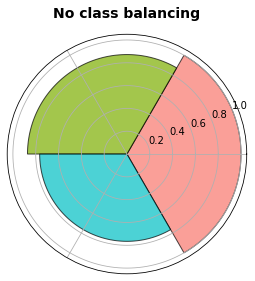

In [35]:
# No class balancing
data = df.iloc[0,:]

make_polar_plot(data, 'No class balancing')

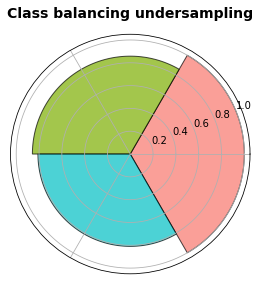

In [36]:
# Class balancing (undersampling)
data = df.iloc[1,:]

make_polar_plot(data, 'Class balancing undersampling')

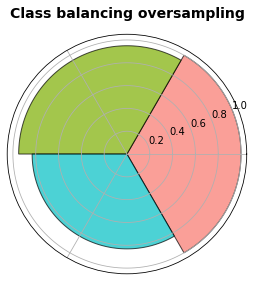

In [37]:
# Class balancing (oversampling)
data = df.iloc[2,:]

make_polar_plot(data, 'Class balancing oversampling')

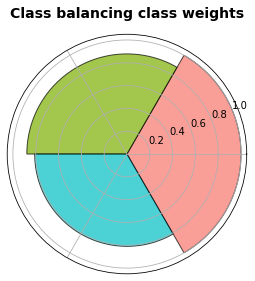

In [38]:
# Class balancing (class weights)
data = df.iloc[3,:]

make_polar_plot(data, 'Class balancing class weights')

# **Save files**

In [39]:
! zip Figure_PolarPlot.zip *.pdf

  adding: Figure_polarplot_MCC_ClassBalancingClassWeights.pdf (deflated 17%)
  adding: Figure_polarplot_MCC_ClassBalancingOversampling.pdf (deflated 17%)
  adding: Figure_polarplot_MCC_ClassBalancingUndersampling.pdf (deflated 17%)
  adding: Figure_polarplot_MCC_df1.pdf (deflated 18%)
  adding: Figure_polarplot_MCC_NoClassBalancing.pdf (deflated 16%)


---

# **Further Resources**

🔴 **Support my work:**
[![Buy me a coffee](https://img.shields.io/badge/Buy%20me%20a%20coffee--yellow.svg?logo=buy-me-a-coffee&logoColor=orange&style=social)](https://www.buymeacoffee.com/dataprofessor)

🟠 **Learn Data Science for FREE:**
[![YouTube](https://img.shields.io/youtube/channel/subscribers/UCV8e2g4IWQqK71bbzGDEI4Q?style=social)](http://youtube.com/dataprofessor)
[![Medium](https://img.shields.io/badge/Medium-12100E?style=for-the-badge&logo=medium&logoColor=white&style=social)](https://medium.com/@chanin.nantasenamat)
[![GitHub](https://img.shields.io/badge/GitHub-100000?style=for-the-badge&style=social&logo=github&logoColor=white)](https://github.com/dataprofessor/)
[![Newsletter](https://img.shields.io/badge/Newsletter-3A8EED?style=for-the-badge&style=social&logoColor=white)](http://newsletter.dataprofessor.org/)
[![DataProfessor](https://img.shields.io/badge/Data-Professor-3A8EED?style=for-the-badge&style=social&logoColor=white)](http://dataprofessor.org/)

🟢 **Learn Python and R for FREE:**
[![Python](https://img.shields.io/badge/Python-3776AB?style=for-the-badge&style=social&logo=python&logoColor=white)](https://www.youtube.com/playlist?list=PL2WsO1N8GK8vMMPQaux9PZaAXBGV7absc)
[![R](https://img.shields.io/badge/R-276DC3?style=for-the-badge&style=social&logo=r&logoColor=white)](https://www.youtube.com/playlist?list=PL2WsO1N8GK8v9xaNwbR1tiGH9lO4epcjg)

🔵 **Connect with me:**
[![Follow](https://img.shields.io/twitter/follow/thedataprof?style=social)](https://www.twitter.com/thedataprof)
[![LinkedIn](https://img.shields.io/badge/LinkedIn-0077B5?style=for-the-badge&style=social&logo=linkedin&logoColor=white)](https://www.linkedin.com/company/dataprofessor/)
[![Facebook](https://img.shields.io/badge/Facebook-1877F2?style=for-the-badge&style=social&logo=facebook&logoColor=white)](http://facebook.com/dataprofessor/)
[![Instagram](https://img.shields.io/badge/Instagram-E4405F?style=for-the-badge&style=social&logo=instagram&logoColor=white)](https://www.instagram.com/data.professor/)